## Self-Attention Does Not Reuire O(N^2) Memory

Implementation of: https://arxiv.org/pdf/2112.05682.pdf

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

### Importing

In [2]:
import numpy as np
import torch
import jax

from linear_mem_attention_pytorch import *
from linear_mem_attention_pytorch.utils import qkv2res
from linear_mem_attention_pytorch.fast_attn import Attention
from linear_mem_attention_pytorch import linear_mem_attn_jax

#### Tests for Pytorch Attention

In [4]:
B, L, D = 1, 2**6, 64
a = torch.randn(B, L, D) # .cuda()
b = a[:, None, :, :]                                           # (b h n d) batch and heads
d = torch.transpose(a, 0, 1).contiguous()
a_ = jax_dlpack.from_dlpack(torch_dlpack.to_dlpack( d )) # (n h d) heads but not batch
a_ = jax.device_put(a_)
b_ = d[None, ...]
c_ = torch.cat([b_, b_], dim=0)
a.shape, a_.shape, b.shape, b_.shape, c_.shape
# attn = Attention(D)
# %timeit attn(a, a)

(torch.Size([1, 64, 64]),
 (64, 1, 64),
 torch.Size([1, 1, 64, 64]),
 torch.Size([1, 64, 1, 64]),
 torch.Size([2, 64, 1, 64]))

In [5]:
jax_attn = jax.jit(linear_mem_attn_jax.attention)
jax_attn(a_, a_, a_)
attention(b_, b_, b_)
qkv2res(b_, b_, b_);

#### Performance Comparison
#### CPU

In [6]:
for exp2 in range(6, 14+1): 
    B, L, D = 1, 2**exp2, 64
    a = torch.randn(B, L, D) # .cuda()
    b = a[:, None, :, :]                                           # (b h n d) batch and heads
    a_ = jax.numpy.asarray(torch.transpose(a, 0, 1).cpu().numpy()) # (n h d) heads but not batch
    b_ = torch.from_numpy( np.asarray(a_) )[None, ...]
    a.shape, a_.shape, b.shape, b_.shape
    # attn = Attention(D)
    # %timeit attn(a, a)
    print()
    print(f"Attn w/ heads=1, batch=1, D=64, For L={2**exp2}")
    print("-> jax compiled linear")
    %timeit jax_attn(a_, a_, a_).block_until_ready()
    print("-> torch linear")
    %timeit attention(b_, b_, b_, query_chunk_size=1024, key_chunk_size=4096)
    print("-> torch standard (einsum is used, but similar to matmul)")
    %timeit qkv2res(b_, b_, b_)


Attn w/ heads=1, batch=1, D=64, For L=64
-> jax compiled linear


2021-12-27 19:20:23.396989: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.0.145, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-12-27 19:20:23.440659: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.0.145, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-12-27 19:20:23.631694: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.0.145, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to 

163 µs ± 16.8 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
-> torch linear
540 µs ± 453 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
-> torch standard (einsum is used, but similar to matmul)
226 µs ± 213 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)

Attn w/ heads=1, batch=1, D=64, For L=128
-> jax compiled linear


2021-12-27 19:20:30.158588: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.0.145, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


168 µs ± 16.4 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
-> torch linear
642 µs ± 443 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
-> torch standard (einsum is used, but similar to matmul)
584 µs ± 792 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)

Attn w/ heads=1, batch=1, D=64, For L=256
-> jax compiled linear


2021-12-27 19:20:40.421311: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.0.145, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


161 µs ± 12.5 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
-> torch linear
999 µs ± 950 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
-> torch standard (einsum is used, but similar to matmul)
2.42 ms ± 1.31 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Attn w/ heads=1, batch=1, D=64, For L=512
-> jax compiled linear


2021-12-27 19:20:50.819194: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.0.145, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


160 µs ± 14 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
-> torch linear
2.12 ms ± 921 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)
-> torch standard (einsum is used, but similar to matmul)
8.29 ms ± 1.15 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Attn w/ heads=1, batch=1, D=64, For L=1024
-> jax compiled linear


2021-12-27 19:20:59.602680: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.0.145, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


178 µs ± 15.8 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
-> torch linear
6.68 ms ± 8.17 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
-> torch standard (einsum is used, but similar to matmul)
31.9 ms ± 8.68 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)

Attn w/ heads=1, batch=1, D=64, For L=2048
-> jax compiled linear


2021-12-27 19:21:07.968591: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.0.145, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


411 µs ± 16.9 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
-> torch linear
25.4 ms ± 81.9 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
-> torch standard (einsum is used, but similar to matmul)
128 ms ± 132 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)

Attn w/ heads=1, batch=1, D=64, For L=4096
-> jax compiled linear


2021-12-27 19:21:20.782667: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.0.145, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


1.24 ms ± 14.7 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
-> torch linear
138 ms ± 4.98 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
-> torch standard (einsum is used, but similar to matmul)
560 ms ± 476 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)

Attn w/ heads=1, batch=1, D=64, For L=8192
-> jax compiled linear


2021-12-27 19:21:36.845905: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.0.145, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


5.08 ms ± 21.5 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
-> torch linear
440 ms ± 15.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
-> torch standard (einsum is used, but similar to matmul)
2.37 s ± 745 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)

Attn w/ heads=1, batch=1, D=64, For L=16384
-> jax compiled linear


2021-12-27 19:21:59.804519: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.0.145, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


19.5 ms ± 31.8 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
-> torch linear
1.75 s ± 12.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
-> torch standard (einsum is used, but similar to matmul)
9.64 s ± 11.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### GPU

In [ ]:
from torch.utils import dlpack as torch_dlpack
from jax import dlpack as jax_dlpack

In [7]:
def wrap_torch_gpu(fn, b_): 
    fn(b_, b_, b_)
    torch.cuda.synchronize()

In [8]:
for exp2 in range(6, 14+1): 
    B, L, D = 1, 2**exp2, 64
    a = torch.randn(B, L, D).cuda()
    b = a[:, None, :, :]                                           # (b h n d) batch and heads
    d = torch.transpose(a, 0, 1).contiguous()
    a_ = jax_dlpack.from_dlpack(torch_dlpack.to_dlpack( d.cpu() )) # (n h d) heads but not batch
    a_ = jax.device_put(a_)
    b_ = d[None, ...]
    c_ = torch.cat([b_, b_], dim=0)
    a.shape, a_.shape, b.shape, b_.shape, c_.shape
    # attn = Attention(D)
    # %timeit attn(a, a)
    print()
    print(f"Attn w/ heads=1, batch=1, D=64, For L={2**exp2}")
    print("-> jax compiled linear")
    %timeit jax_attn(a_, a_, a_).block_until_ready()
    print("-> torch linear")
    %timeit wrap_torch_gpu(attention, b_) #  attention(b_, b_, b_, query_chunk_size=1024, key_chunk_size=4096); torch.cuda.synchronize()
    print("-> torch standard (einsum is used, but similar to matmul)")
    %timeit wrap_torch_gpu(qkv2res, b_) # qkv2res(b_, b_, b_); torch.cuda.synchronize()


Attn w/ heads=1, batch=1, D=64, For L=64
-> jax compiled linear
54.8 µs ± 111 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
-> torch linear
1.01 ms ± 943 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
-> torch standard (einsum is used, but similar to matmul)
147 µs ± 257 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)

Attn w/ heads=1, batch=1, D=64, For L=128
-> jax compiled linear
193 µs ± 20 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
-> torch linear
1.03 ms ± 1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
-> torch standard (einsum is used, but similar to matmul)
150 µs ± 284 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)

Attn w/ heads=1, batch=1, D=64, For L=256
-> jax compiled linear
938 µs ± 47.9 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
-> torch linear
1.1 ms ± 387 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
-> torch standard (einsum is used, but similar to matmul)
187 µs ± 98.6 ns 

RuntimeError: The following operation failed in the TorchScript interpreter.
Traceback of TorchScript (most recent call last):
  File "/home/ubuntu/linear_mem_attention_pytorch/linear_mem_attention_pytorch/utils.py", line 10, in qkv2res
    """ Inputs must be in (b n h d) format. """  
    # return (q @ torch.transpose(k, -1, -2)).softmax(dim=-1) @ v
    qk = torch.einsum('b i h d, b j h d -> b i h j', q, k).softmax(dim=-1)
         ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ <--- HERE
    return torch.einsum('b i h j, b j h d -> b i h d', qk, v)
RuntimeError: CUDA out of memory. Tried to allocate 256.00 MiB (GPU 0; 15.78 GiB total capacity; 262.00 MiB already allocated; 218.75 MiB free; 272.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


### Compare to community implementation (L = 2**14)

In [9]:
from memory_efficient_attention import efficient_dot_product_attention_pt

#### CPU

In [10]:
print("Community implementation")
%timeit efficient_dot_product_attention_pt(*[b_.cpu()]*3, key_chunk_size=1024, query_chunk_size=4096)

Community implementation
0
4096
0
4096
0
4096
0
4096
0
4096
0
4096
0
4096
0
4096
575 ms ± 16 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
print("Our implementation")
%timeit attention( *[b_.cpu()]*3 , key_chunk_size=1024, query_chunk_size=4096)

Our implementation
488 ms ± 32.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### GPU

In [15]:
print("Community implementation")
try: 
    %timeit efficient_dot_product_attention_pt(b_, b_, b_, key_chunk_size=1024, query_chunk_size=4096)
except Exception as e: 
    print("Failed. See error (uncomment the try/except for more info):\n")
    print(e)

Community implementation
0
Failed. See error (uncomment the try/except for more info):

Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument index in method wrapper__index_select)


In [16]:
print("Our implementation")
%timeit attention(b_, b_, b_, key_chunk_size=1024, query_chunk_size=4096)

Our implementation
11.9 ms ± 7.42 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Visualize

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("runtime_data_times.csv")
df.head(10);

In [3]:
x = "cpu" # gpu

In [4]:
def get_plot(x):
    plt.figure(figsize=(9, 6))
    plt.title(f"{x.upper()} runtimes")
    for var in [f"jax_{x}", f"torch_{x}", f"torch_einsum_{x}"]:
        plt.plot(df[var].values, 'o-', label=var)

    plt.ylabel("Runtime (seconds)")
    plt.xlabel("Sequence length")
    plt.xticks( np.arange(df.shape[0]), 2 ** (6 + np.arange(df.shape[0]) ) )
    plt.yscale("log")
    plt.legend()
    # plt.grid()
    plt.show()

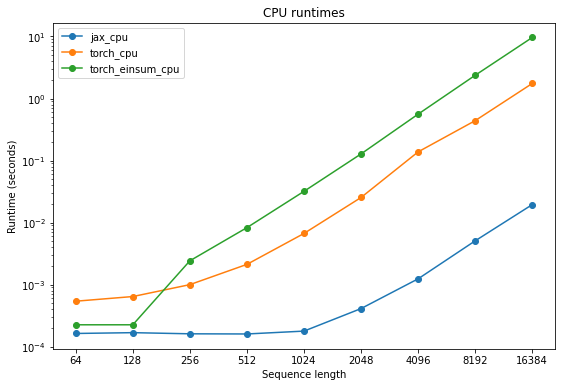

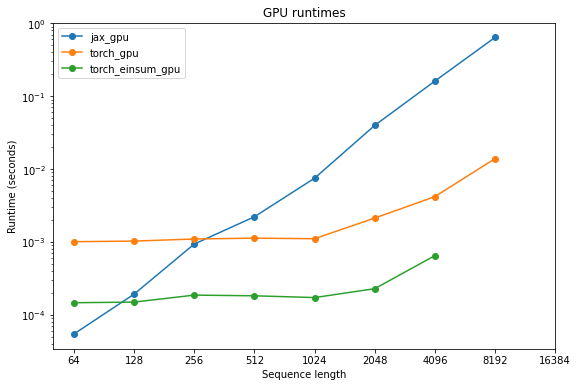

In [5]:
get_plot("cpu"); get_plot("gpu")